## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [ ]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [ ]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_ROOT = "/content/drive/MyDrive/hotdog_nothotdog"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path=DATA_ROOT):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]

        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [ ]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Let's look at some images from our data

In [ ]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


KeyboardInterrupt: 

Now create a model and train it!


In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
        nn.Conv2d(in_channels= 3, out_channels=32, kernel_size=3, padding=1),nn.BatchNorm2d(32),nn.ReLU(),
        nn.Conv2d(in_channels= 32, out_channels=64, kernel_size=3, padding=1),nn.BatchNorm2d(64),nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(in_channels= 64, out_channels=128, kernel_size=3, padding=1),nn.BatchNorm2d(128), nn.ReLU(),
        nn.Conv2d(in_channels= 128, out_channels=128, kernel_size=3, padding=1),nn.BatchNorm2d(128),nn.ReLU()
        )

        self.fully_connected = nn.Sequential(
          nn.Linear(128*64*64, 500),
          nn.ReLU(),
          nn.Linear(500, 10))

    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [ ]:
from torchvision.models import alexnet,vgg13_bn, vgg19_bn,  inception_v3, resnet50, resnet152, densenet161, densenet201, efficientnet_b4, efficientnet_b6

models = []
model = alexnet(weights=None)
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 2)
models.append(model)

model = vgg13_bn(weights=None)
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 2)
models.append(model)

model = vgg19_bn(weights=None)
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 2)
models.append(model)

#model = inception_v3(weights=None, aux_logits=False)
#model.fc = torch.nn.Linear(model.fc.in_features, 2)
#models.append(model)

model = resnet50(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
models.append(model)

model = resnet152(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
models.append(model)

model = densenet161(weights=None)
model.classifier = torch.nn.Linear(model.classifier.in_features, 2)
models.append(model)

model = densenet201(weights=None)
model.classifier = torch.nn.Linear(model.classifier.in_features, 2)
models.append(model)

model = efficientnet_b4(weights=None)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)
models.append(model)
model = efficientnet_b6(weights=None)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)
models.append(model)

/usr/local/lib/python3.12/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [1]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    loss_fun = nn.CrossEntropyLoss()
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}

    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

In [ ]:
results = []
for model in models:
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  model.to(device)
  results.append(train(model, optimizer, num_epochs=15))

  0%|          | 0/15 [00:00<?, ?epoch/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.709	 test: 0.698	 Accuracy train: 53.2%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.692	 test: 0.695	 Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.693	 test: 0.697	 Accuracy train: 52.2%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.693	 test: 0.695	 Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.693	 test: 0.697	 Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.692	 test: 0.696	 Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.692	 test: 0.698	 Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.692	 test: 0.696	 Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

KeyboardInterrupt: 

##Putting the results together


In [ ]:
for result in results:
  print(result)

{'train_acc': [0.48851978505129456, 0.5227161700048852, 0.6057645334636053, 0.5657059110893992, 0.5696140693698095, 0.5930630190522717, 0.6844162188568637, 0.7171470444553004, 0.666829506595017, 0.7366878358573522, 0.7484123106985833, 0.7303370786516854, 0.7699071812408402, 0.7782120175867122, 0.7752808988764045], 'test_acc': [0.4806659505907626, 0.4806659505907626, 0.5220193340494093, 0.5612244897959183, 0.48603651987110635, 0.6288936627282492, 0.69656283566058, 0.625671321160043, 0.6987110633727175, 0.6928034371643395, 0.7175080558539205, 0.7373791621911923, 0.7389903329752954, 0.7051557465091299, 0.7271750805585392], 'train_loss': [np.float64(0.7311436254531145), np.float64(0.6902681011706591), np.float64(0.6586124934256077), np.float64(0.6874098479747772), np.float64(0.6907763779163361), np.float64(0.6712230760604143), np.float64(0.6041705943644047), np.float64(0.5805131327360868), np.float64(0.6270800642669201), np.float64(0.5611955095082521), np.float64(0.5288595631718636), np.fl

In [ ]:
import re, ast

raw = """
{'Name': "AlexNet", 'train_acc': [0.48851978505129456, 0.5227161700048852, 0.6057645334636053, 0.5657059110893992, 0.5696140693698095, 0.5930630190522717, 0.6844162188568637, 0.7171470444553004, 0.666829506595017, 0.7366878358573522, 0.7484123106985833, 0.7303370786516854, 0.7699071812408402, 0.7782120175867122, 0.7752808988764045], 'test_acc': [0.4806659505907626, 0.4806659505907626, 0.5220193340494093, 0.5612244897959183, 0.48603651987110635, 0.6288936627282492, 0.69656283566058, 0.625671321160043, 0.6987110633727175, 0.6928034371643395, 0.7175080558539205, 0.7373791621911923, 0.7389903329752954, 0.7051557465091299, 0.7271750805585392], 'train_loss': [np.float64(0.7311436254531145), np.float64(0.6902681011706591), np.float64(0.6586124934256077), np.float64(0.6874098479747772), np.float64(0.6907763779163361), np.float64(0.6712230760604143), np.float64(0.6041705943644047), np.float64(0.5805131327360868), np.float64(0.6270800642669201), np.float64(0.5611955095082521), np.float64(0.5288595631718636), np.float64(0.537388788536191), np.float64(0.4815087718889117), np.float64(0.48922291677445173), np.float64(0.4820363614708185)], 'test_loss': [np.float64(0.693427437543869), np.float64(0.7632245858510335), np.float64(0.689445988337199), np.float64(0.6798622936010361), np.float64(0.6863258401552836), np.float64(0.6461927205324173), np.float64(0.6262171864509583), np.float64(0.6419249812761942), np.float64(0.5924896627664566), np.float64(0.5717833191156387), np.float64(0.5692736799518268), np.float64(0.5518382082382838), np.float64(0.5770233829816183), np.float64(0.6017282247543335), np.float64(0.540881576637427)]}
{'Name': "vgg13_bn",'train_acc': [0.5080605764533463, 0.5026868588177821, 0.5095261358085003, 0.5227161700048852, 0.5236932095749878, 0.5222276502198339, 0.5319980459208598, 0.525647288715193, 0.5764533463605276, 0.6580361504640938, 0.6712261846604788, 0.7034684904738642, 0.7318026380068393, 0.7557401074743527, 0.7542745481191988], 'test_acc': [0.4806659505907626, 0.495703544575725, 0.5075187969924813, 0.5112781954887218, 0.4833512352309345, 0.5042964554242749, 0.4849624060150376, 0.5048335123523093, 0.658968850698174, 0.6766917293233082, 0.6852846401718582, 0.5886143931256713, 0.7126745435016112, 0.6245972073039742, 0.6326530612244898], 'train_loss': [np.float64(9.275063119828701), np.float64(0.7325098551809788), np.float64(0.7426791395992041), np.float64(0.7096197139471769), np.float64(0.6987210232764482), np.float64(0.7035584021359682), np.float64(0.721199743449688), np.float64(0.7206432353705168), np.float64(0.7042439915239811), np.float64(0.6594348475337029), np.float64(0.6363064888864756), np.float64(0.5991468830034137), np.float64(0.5562013685703278), np.float64(0.5408083843067288), np.float64(0.5456254938617349)], 'test_loss': [np.float64(0.7191999812920888), np.float64(0.6977099816004435), np.float64(0.6915186266104381), np.float64(0.7008524219195048), np.float64(0.7035880585511526), np.float64(0.6922954976558685), np.float64(0.7197472850481669), np.float64(0.6964404741923015), np.float64(0.634106860558192), np.float64(0.627224846680959), np.float64(0.5958239446083705), np.float64(0.6838977724313736), np.float64(0.6846572920680046), np.float64(0.8207024815181891), np.float64(0.6784193535645803)]}
{'Name': "vgg19_bn",'train_acc': [0.4880312652662433, 0.5188080117244749, 0.5266243282852956, 0.5227161700048852, 0.5183194919394235, 0.5393258426966292, 0.524181729360039, 0.5163654127992183, 0.5828041035661944, 0.655105031753786, 0.680019540791402, 0.6756228627259404, 0.7142159257449927, 0.7283829995114802, 0.7435271128480704], 'test_acc': [0.4806659505907626, 0.48442534908700324, 0.5010741138560687, 0.4806659505907626, 0.48442534908700324, 0.4940923737916219, 0.49624060150375937, 0.5703544575725027, 0.6611170784103115, 0.6697099892588615, 0.6723952738990333, 0.6750805585392051, 0.7352309344790547, 0.7459720730397422, 0.6992481203007519], 'train_loss': [np.float64(7.592355726286769), np.float64(0.8645626474171877), np.float64(0.8085560500621796), np.float64(0.7122009359300137), np.float64(0.7160707451403141), np.float64(0.695672644302249), np.float64(0.703281007707119), np.float64(0.7142615262418985), np.float64(0.6922761704772711), np.float64(0.6422864254564047), np.float64(0.6392371617257595), np.float64(0.6241326862946153), np.float64(0.602043435908854), np.float64(0.572532813064754), np.float64(0.542303261347115)], 'test_loss': [np.float64(0.7731438299020131), np.float64(0.9456956764062245), np.float64(0.7048340896765392), np.float64(0.7540398081143697), np.float64(0.7188283642133076), np.float64(0.6994657079378764), np.float64(0.7448499063650768), np.float64(0.6933883428573608), np.float64(0.6383684267600377), np.float64(0.6444981336593628), np.float64(0.6402479509512583), np.float64(0.6115933497746785), np.float64(0.5538618663946787), np.float64(0.5733175923426946), np.float64(0.6171202778816223)]}
{'Name': "resnet50",'train_acc': [0.6502198339032731, 0.7733268197361993, 0.8016609672691744, 0.8216902784562775, 0.8500244259892525, 0.8744504152418173, 0.8891060087933561, 0.9174401563263312, 0.9159745969711773, 0.940400586223742, 0.9223253541768441, 0.9345383488031265, 0.9672691744015632, 0.9848558866634098, 0.9775280898876404], 'test_acc': [0.5725026852846402, 0.7368421052631579, 0.664876476906552, 0.6654135338345865, 0.6858216970998926, 0.6970998925886144, 0.7089151450053706, 0.7529538131041891, 0.6095596133190118, 0.7631578947368421, 0.6165413533834586, 0.7223415682062299, 0.6557465091299678, 0.7755102040816326, 0.7234156820622986], 'train_loss': [np.float64(0.8022947963327169), np.float64(0.5010210173204541), np.float64(0.46349837351590395), np.float64(0.4800900937989354), np.float64(0.37619945453479886), np.float64(0.2993182288482785), np.float64(0.26588596659712493), np.float64(0.22761676157824695), np.float64(0.20206017000600696), np.float64(0.16002833296079189), np.float64(0.20019900263287127), np.float64(0.16304857830982655), np.float64(0.09582075936486945), np.float64(0.04710142547264695), np.float64(0.06697199752670713)], 'test_loss': [np.float64(0.8641610915462176), np.float64(0.5657484054565429), np.float64(0.829359358549118), np.float64(2.0608018204569816), np.float64(1.030112830052773), np.float64(0.8709536086767912), np.float64(0.7165819555521011), np.float64(0.775167233000199), np.float64(1.2758288010954857), np.float64(0.8393914302190145), np.float64(2.255528270204862), np.float64(0.8522201620042325), np.float64(1.553634622444709), np.float64(1.0272338750461738), np.float64(1.2623452400167783)]}
{'Name': "resnet152",'train_acc': [0.5476306790425012, 0.6638983878847093, 0.7313141182217879, 0.7674645823155838, 0.7796775769418661, 0.8075232046897899, 0.8436736687835857, 0.8475818270639961, 0.8720078163165608, 0.8866634098680997, 0.8637029799706888, 0.9140205178309722, 0.8954567659990229, 0.8959452857840743, 0.852467024914509], 'test_acc': [0.4806659505907626, 0.6707841031149302, 0.6917293233082706, 0.7142857142857143, 0.6992481203007519, 0.7443609022556391, 0.7180451127819549, 0.715359828141783, 0.7406015037593985, 0.7105263157894737, 0.6455424274973147, 0.6455424274973147, 0.7389903329752954, 0.6568206229860365, 0.7518796992481203], 'train_loss': [np.float64(0.8917481396347284), np.float64(0.6576127912849188), np.float64(0.5936464183032513), np.float64(0.5824227901175618), np.float64(0.49903993774205446), np.float64(0.4341424060985446), np.float64(0.4126716433092952), np.float64(0.3795394590124488), np.float64(0.3081863480620086), np.float64(0.2830235934816301), np.float64(0.3417885024100542), np.float64(0.23912254453171045), np.float64(0.2660307502374053), np.float64(0.26087427418679), np.float64(0.3228150480426848)], 'test_loss': [np.float64(0.9155325735608737), np.float64(0.6238509863615036), np.float64(0.6637520144383112), np.float64(0.6962200204531351), np.float64(0.6199139535427094), np.float64(0.7062415108084679), np.float64(0.5970335920651754), np.float64(0.9432202994823455), np.float64(0.7076967179775238), np.float64(0.7056572000185649), np.float64(1.1305590726435184), np.float64(1.4054781725009282), np.float64(0.7015482261776924), np.float64(1.303498496611913), np.float64(0.6337112501263619)]}
{'Name': "densenet161",'train_acc': [0.6980947728382999, 0.7782120175867122, 0.7855398143624817, 0.7982413287738154, 0.8089887640449438, 0.8412310698583293, 0.8348803126526624, 0.8466047874938935, 0.8695652173913043, 0.865657059110894, 0.8768930141670738, 0.8949682462139716, 0.8817782120175867, 0.8607718612603811, 0.9027845627747924], 'test_acc': [0.7261009667024705, 0.7185821697099892, 0.7894736842105263, 0.7459720730397422, 0.6106337271750806, 0.80343716433942, 0.7851772287862513, 0.8098818474758325, 0.7545649838882922, 0.8039742212674543, 0.80343716433942, 0.7964554242749732, 0.7336197636949516, 0.6568206229860365, 0.7755102040816326], 'train_loss': [np.float64(0.6521603967994452), np.float64(0.48971568048000336), np.float64(0.4870593184605241), np.float64(0.4395723473280668), np.float64(0.41128136310726404), np.float64(0.37125223269686103), np.float64(0.383782341144979), np.float64(0.358037818223238), np.float64(0.31468853587284684), np.float64(0.31262738117948174), np.float64(0.295667196623981), np.float64(0.2431092243641615), np.float64(0.2902801192831248), np.float64(0.30380334611982107), np.float64(0.23760703671723604)], 'test_loss': [np.float64(0.6552126427491506), np.float64(0.6442564912140369), np.float64(0.4814742142955462), np.float64(0.5574675550063452), np.float64(1.3158999145651857), np.float64(0.43199774871269864), np.float64(0.52318618260324), np.float64(0.4812350963552793), np.float64(0.6162867850313584), np.float64(0.6053062875755131), np.float64(0.5015260051315029), np.float64(0.5227539269874494), np.float64(0.5583530068397522), np.float64(0.966236910627534), np.float64(0.5648612912744284)]}
{'Name': "densenet201",'train_acc': [0.6917440156326331, 0.7576941866145579, 0.8065461651196874, 0.8172936003908158, 0.8373229115779189, 0.8549096238397655, 0.8505129457743038, 0.8832437713727406, 0.8886174890083048, 0.8998534440644846, 0.8954567659990229, 0.9106008793356131, 0.9325842696629213, 0.9389350268685882, 0.9335613092330239], 'test_acc': [0.7019334049409237, 0.771750805585392, 0.7529538131041891, 0.7685284640171858, 0.7561761546723953, 0.7502685284640171, 0.7277121374865736, 0.8050483351235231, 0.7787325456498388, 0.7191192266380236, 0.7212674543501612, 0.7636949516648764, 0.6702470461868958, 0.7679914070891515, 0.7303974221267454], 'train_loss': [np.float64(0.6210701102390885), np.float64(0.5059903869405389), np.float64(0.4265580512583256), np.float64(0.40714538749307394), np.float64(0.36357207549735904), np.float64(0.3350968868471682), np.float64(0.3332854830659926), np.float64(0.2872513234615326), np.float64(0.27239401591941714), np.float64(0.24137070612050593), np.float64(0.25984076503664255), np.float64(0.21603362867608666), np.float64(0.17458399035967886), np.float64(0.16520273312926292), np.float64(0.16613733978010714)], 'test_loss': [np.float64(0.6674421042203903), np.float64(0.5900862336158752), np.float64(0.5668809498349826), np.float64(0.5892462437351544), np.float64(0.6563102799157302), np.float64(0.5528054232398669), np.float64(1.0543931992103657), np.float64(0.4867444510261218), np.float64(0.9952109071115652), np.float64(0.8039100801649813), np.float64(0.8527987310041983), np.float64(0.6885422425965468), np.float64(0.858864360054334), np.float64(0.7115586216251055), np.float64(0.9532750484844049)]}
{'Name': "efficientnet_b4",'train_acc': [0.5207620908646801, 0.5881778212017587, 0.680019540791402, 0.7210552027357108, 0.7498778700537372, 0.7850512945774304, 0.7938446507083536, 0.8124084025403029, 0.8568637029799707, 0.873961895456766, 0.9003419638495359, 0.8871519296531509, 0.9164631167562286, 0.9086468001954079, 0.9228138739618954], 'test_acc': [0.5193340494092373, 0.4806659505907626, 0.700859291084855, 0.7024704618689581, 0.7363050483351236, 0.7481203007518797, 0.7647690655209453, 0.706766917293233, 0.7411385606874329, 0.7212674543501612, 0.709452201933405, 0.7551020408163265, 0.765843179377014, 0.742749731471536, 0.7438238453276047], 'train_loss': [np.float64(0.755814703181386), np.float64(0.7113934215158224), np.float64(0.6477153208106756), np.float64(0.609376884996891), np.float64(0.5686407992616296), np.float64(0.5108896093443036), np.float64(0.4671897664666176), np.float64(0.4307660423219204), np.float64(0.35411211010068655), np.float64(0.31432155054062605), np.float64(0.2762421639636159), np.float64(0.29022951889783144), np.float64(0.22571303299628198), np.float64(0.229594950331375), np.float64(0.1760801167692989)], 'test_loss': [np.float64(0.6915001014868418), np.float64(0.6924619853496552), np.float64(0.9081325928370158), np.float64(0.7798934360345204), np.float64(0.5909831623236338), np.float64(0.5619236558675766), np.float64(0.5825493017832438), np.float64(0.7018606637914976), np.float64(0.6510872587561607), np.float64(0.5941462313135465), np.float64(0.7175831303000451), np.float64(0.6284406299392382), np.float64(0.6772500585764647), np.float64(0.6582215974728266), np.float64(0.8927115460236867)]}
{'Name': "efficientnet_b6",'train_acc': [0.4870542256961407, 0.504152418172936, 0.5153883732291158, 0.5153883732291158, 0.5246702491450904, 0.6389838788470933, 0.6941866145578895, 0.7493893502686859, 0.7484123106985833, 0.7699071812408402, 0.7850512945774304, 0.7967757694186615, 0.8128969223253542, 0.8236443575964827, 0.8343917928676111], 'test_acc': [0.4806659505907626, 0.4806659505907626, 0.4806659505907626, 0.4806659505907626, 0.4806659505907626, 0.4806659505907626, 0.4806659505907626, 0.4806659505907626, 0.4806659505907626, 0.4806659505907626, 0.4806659505907626, 0.4806659505907626, 0.4806659505907626, 0.4806659505907626, 0.4806659505907626], 'train_loss': [np.float64(0.8040340188890696), np.float64(0.7361610271036625), np.float64(0.7333491910248995), np.float64(0.7275457959622145), np.float64(0.6997002214193344), np.float64(0.6860842723399401), np.float64(0.6250279303640127), np.float64(0.5488341776654124), np.float64(0.5589242428541183), np.float64(0.5020446218550205), np.float64(0.4930853098630905), np.float64(0.4630394596606493), np.float64(0.4384520063176751), np.float64(0.4083829540759325), np.float64(0.39347720798105)], 'test_loss': [np.float64(0.7011350234349568), np.float64(0.6996670265992483), np.float64(0.695439463853836), np.float64(0.6998155395189921), np.float64(0.7053070207436879), np.float64(0.7035076042016347), np.float64(0.7052374521891276), np.float64(0.7066363215446472), np.float64(0.6979444901148478), np.float64(0.6992155651251475), np.float64(0.7028636932373047), np.float64(0.7109996596972148), np.float64(0.7074590007464091), np.float64(0.7139172613620758), np.float64(0.7068133254845937)]}
"""
import re, ast

def parse_models(raw: str):
    # 1) drop np.float64(...) wrappers → just keep the inner number
    cleaned = re.sub(r'np\.float64\(([^)]+)\)', r'\1', raw.strip())
    # 2) stitch the separate dicts into a list literal
    as_list_literal = '[' + re.sub(r'}\s*{', '}, {', cleaned) + ']'
    # 3) safely parse to Python objects
    return ast.literal_eval(as_list_literal)

models = parse_models(raw)

# quick sanity checks
print(type(models), len(models))
print(models[0]['Name'], len(models[0]['train_acc']))

<class 'list'> 9
AlexNet 15


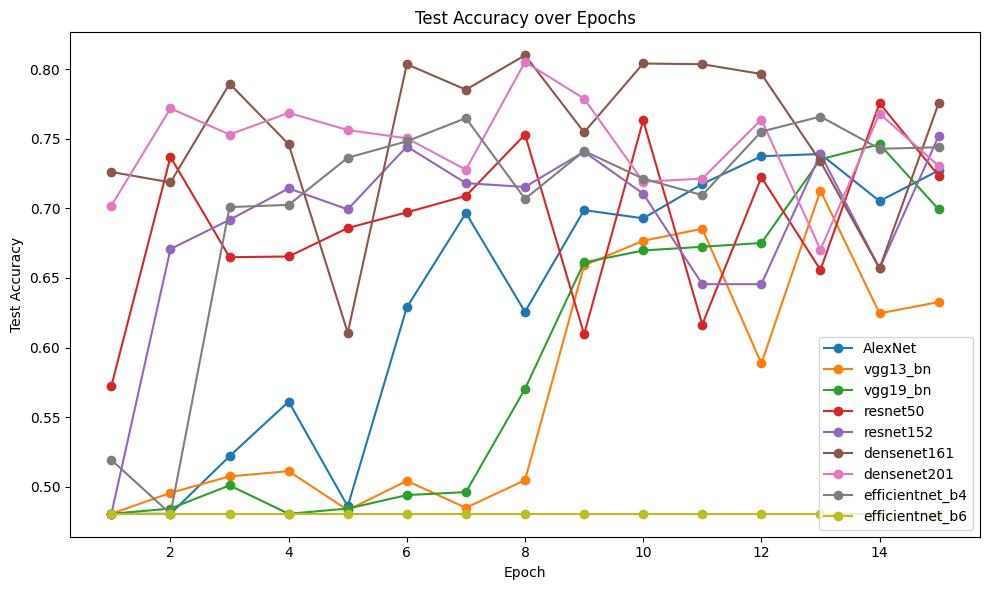

In [ ]:

import re, ast, pandas as pd, numpy as np
import matplotlib.pyplot as plt

def parse_models(raw: str):
    cleaned = re.sub(r'np\.float64\(([^)]+)\)', r'\1', raw.strip())
    as_list_literal = '[' + re.sub(r'}\s*{', '}, {', cleaned) + ']'
    return ast.literal_eval(as_list_literal)

models = parse_models(raw)

# Test accuracy over epochs
plt.figure(figsize=(10,6))
for m in models:
    y = np.array(m['test_acc'], dtype=float)
    x = np.arange(1, len(y)+1)
    plt.plot(x, y, marker='o', label=m['Name'])
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

##ADDING AUGMENTATION

In [13]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class AlbumentationsTransform:
    def __init__(self, size=224, augment=True):
        aug = []
        if augment:
            aug = [
                A.Blur(blur_limit=10),
                A.RandomBrightnessContrast(brightness_limit=[-0.2, 0.2], contrast_limit=[-0.2, 0.2]),
                A.GaussNoise(std_range=[0.01, 0.1], mean_range=[0.01, 0.1]),
                A.HorizontalFlip(p=0.5),
                A.Rotate(limit=[15,45]),
            ]
        # Use standard normalization for pretrained models (ImageNet)
        self.transform = A.Compose(aug + [
            A.SmallestMaxSize(max_size=size),
            A.RandomCrop(width=size, height=size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # <--- Key!
            ToTensorV2()
        ])
    def __call__(self, img):
        img = np.array(img)
        img = self.transform(image=img)['image']
        return img

In [14]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torchvision.models import alexnet,vgg13_bn, vgg19_bn,  inception_v3, resnet50, resnet152, densenet161, densenet201, efficientnet_b4, efficientnet_b6

if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from google.colab import drive
drive.mount('/content/drive')
DATA_ROOT = "/content/drive/MyDrive/hotdog_nothotdog"

class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path=DATA_ROOT):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]

        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

size = 224
train_transform = AlbumentationsTransform(size=size, augment=True)
test_transform = AlbumentationsTransform(size=size, augment=False)
batch_size = 32
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

model = densenet161(weights=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.classifier = torch.nn.Linear(model.classifier.in_features, 2)
model.to(device)

train(model, optimizer, num_epochs=15)


The code will run on GPU.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/15 [00:00<?, ?epoch/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.502	 test: 0.456	 Accuracy train: 77.6%	 test: 78.1%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.428	 test: 0.410	 Accuracy train: 80.7%	 test: 80.7%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.354	 test: 0.642	 Accuracy train: 84.8%	 test: 73.1%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.356	 test: 0.363	 Accuracy train: 84.0%	 test: 84.6%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.339	 test: 0.368	 Accuracy train: 85.6%	 test: 84.2%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.313	 test: 0.463	 Accuracy train: 87.1%	 test: 81.0%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.317	 test: 0.418	 Accuracy train: 86.7%	 test: 82.7%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.301	 test: 0.328	 Accuracy train: 86.7%	 test: 86.1%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.272	 test: 0.425	 Accuracy train: 88.8%	 test: 82.7%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.275	 test: 0.324	 Accuracy train: 88.8%	 test: 86.8%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.275	 test: 0.373	 Accuracy train: 88.7%	 test: 84.6%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.266	 test: 0.364	 Accuracy train: 89.1%	 test: 86.0%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.252	 test: 0.333	 Accuracy train: 89.0%	 test: 86.3%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.228	 test: 0.379	 Accuracy train: 89.8%	 test: 85.4%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.232	 test: 0.361	 Accuracy train: 90.8%	 test: 85.9%


{'train_acc': [0.776257938446507,
  0.8070346849047386,
  0.8475818270639961,
  0.8402540302882266,
  0.8563751831949193,
  0.870542256961407,
  0.8671226184660479,
  0.8666340986809966,
  0.8881289692232536,
  0.8881289692232536,
  0.8871519296531509,
  0.89057156814851,
  0.8900830483634588,
  0.8983878847093307,
  0.9081582804103566],
 'test_acc': [0.7808807733619764,
  0.8071965628356605,
  0.7314715359828142,
  0.8458646616541353,
  0.8421052631578947,
  0.8098818474758325,
  0.8270676691729323,
  0.8614393125671321,
  0.826530612244898,
  0.8678839957035446,
  0.8458646616541353,
  0.859828141783029,
  0.8625134264232008,
  0.8544575725026853,
  0.8592910848549946],
 'train_loss': [np.float64(0.5024173120036721),
  np.float64(0.4284455415327102),
  np.float64(0.3542873209808022),
  np.float64(0.35595717490650713),
  np.float64(0.33932794141583145),
  np.float64(0.3131068889051676),
  np.float64(0.31731405085884035),
  np.float64(0.30104243848472834),
  np.float64(0.27173414779827